In [32]:
#Импорт библиотек и модулей
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import data_preprocessing as dp
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
from sklearn.preprocessing import LabelEncoder

In [33]:
#Загрузка датасета
data = pd.read_csv('online_gaming_behavior_dataset.csv')
data

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40029,49029,32,Male,USA,Strategy,20.619662,0,Easy,4,75,85,14,Medium
40030,49030,44,Female,Other,Simulation,13.539280,0,Hard,19,114,71,27,High
40031,49031,15,Female,USA,RPG,0.240057,1,Easy,10,176,29,1,High
40032,49032,34,Male,USA,Sports,14.017818,1,Medium,3,128,70,10,Medium


In [34]:
#Удаление ненужных данных
data = data.drop(columns=['PlayerID', 'InGamePurchases'])

In [35]:
#Проверка на пропущенные значения
print(dp.missing_values_report(data))

Series([], dtype: int64)


In [36]:
#Статистика колонок датасета
data.describe()

,Age,PlayTimeHours,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked
count,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000,40034.000000
mean,31.992531,12.024365,9.471774,94.792252,49.655568,24.526477
std,10.043227,6.914638,5.763667,49.011375,28.588379,14.430726
min,15.000000,0.000115,0.000000,10.000000,1.000000,0.000000
25%,23.000000,6.067501,4.000000,52.000000,25.000000,12.000000
50%,32.000000,12.008002,9.000000,95.000000,49.000000,25.000000
75%,41.000000,17.963831,14.000000,137.000000,74.000000,37.000000
max,49.000000,23.999592,19.000000,179.000000,99.000000,49.000000


In [41]:
#Создание БД
conn = sqlite3.connect('gaming_dataset.db')
cursor = conn.cursor()

cursor.execute('''CREATE TABLE IF NOT EXISTS dataset (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    age INTEGER,
    gender TEXT,
    location TEXT,
    game_genre TEXT,
    play_time FLOAT,
    game_difficulty TEXT,
    sessions_per_week INTEGER,
    avg_session_duration INTEGER,
    player_level INTEGER,
    achievements INTEGER,
    engagement_level
)''')

In [42]:
#Преобразование данных и отправка их в базу данных
data_for_DB = []
for idx, row in data.iterrows():
    data_for_DB.append(tuple(row))

cursor.executemany("INSERT INTO dataset (age, gender, location, game_genre, play_time, game_difficulty, sessions_per_week, avg_session_duration, player_level, achievements, engagement_level) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)", data_for_DB)

In [44]:
#Кол-во 15-их игроков
cursor.execute("SELECT COUNT(*) FROM dataset WHERE age = 15")
cursor.fetchall()

[(1101,)]

In [45]:
#Среднияя продолжительность игровой сессии у игроков до 20/30/40 лет
cursor.execute("SELECT AVG(avg_session_duration) FROM dataset WHERE age < 20")
print(cursor.fetchall())

cursor.execute("SELECT AVG(avg_session_duration) FROM dataset WHERE age < 30")
print(cursor.fetchall())

cursor.execute("SELECT AVG(avg_session_duration) FROM dataset WHERE age < 40")
print(cursor.fetchall())

[(95.18984896382156,)]
[(94.4962269669494,)]
[(94.95487541006491,)]


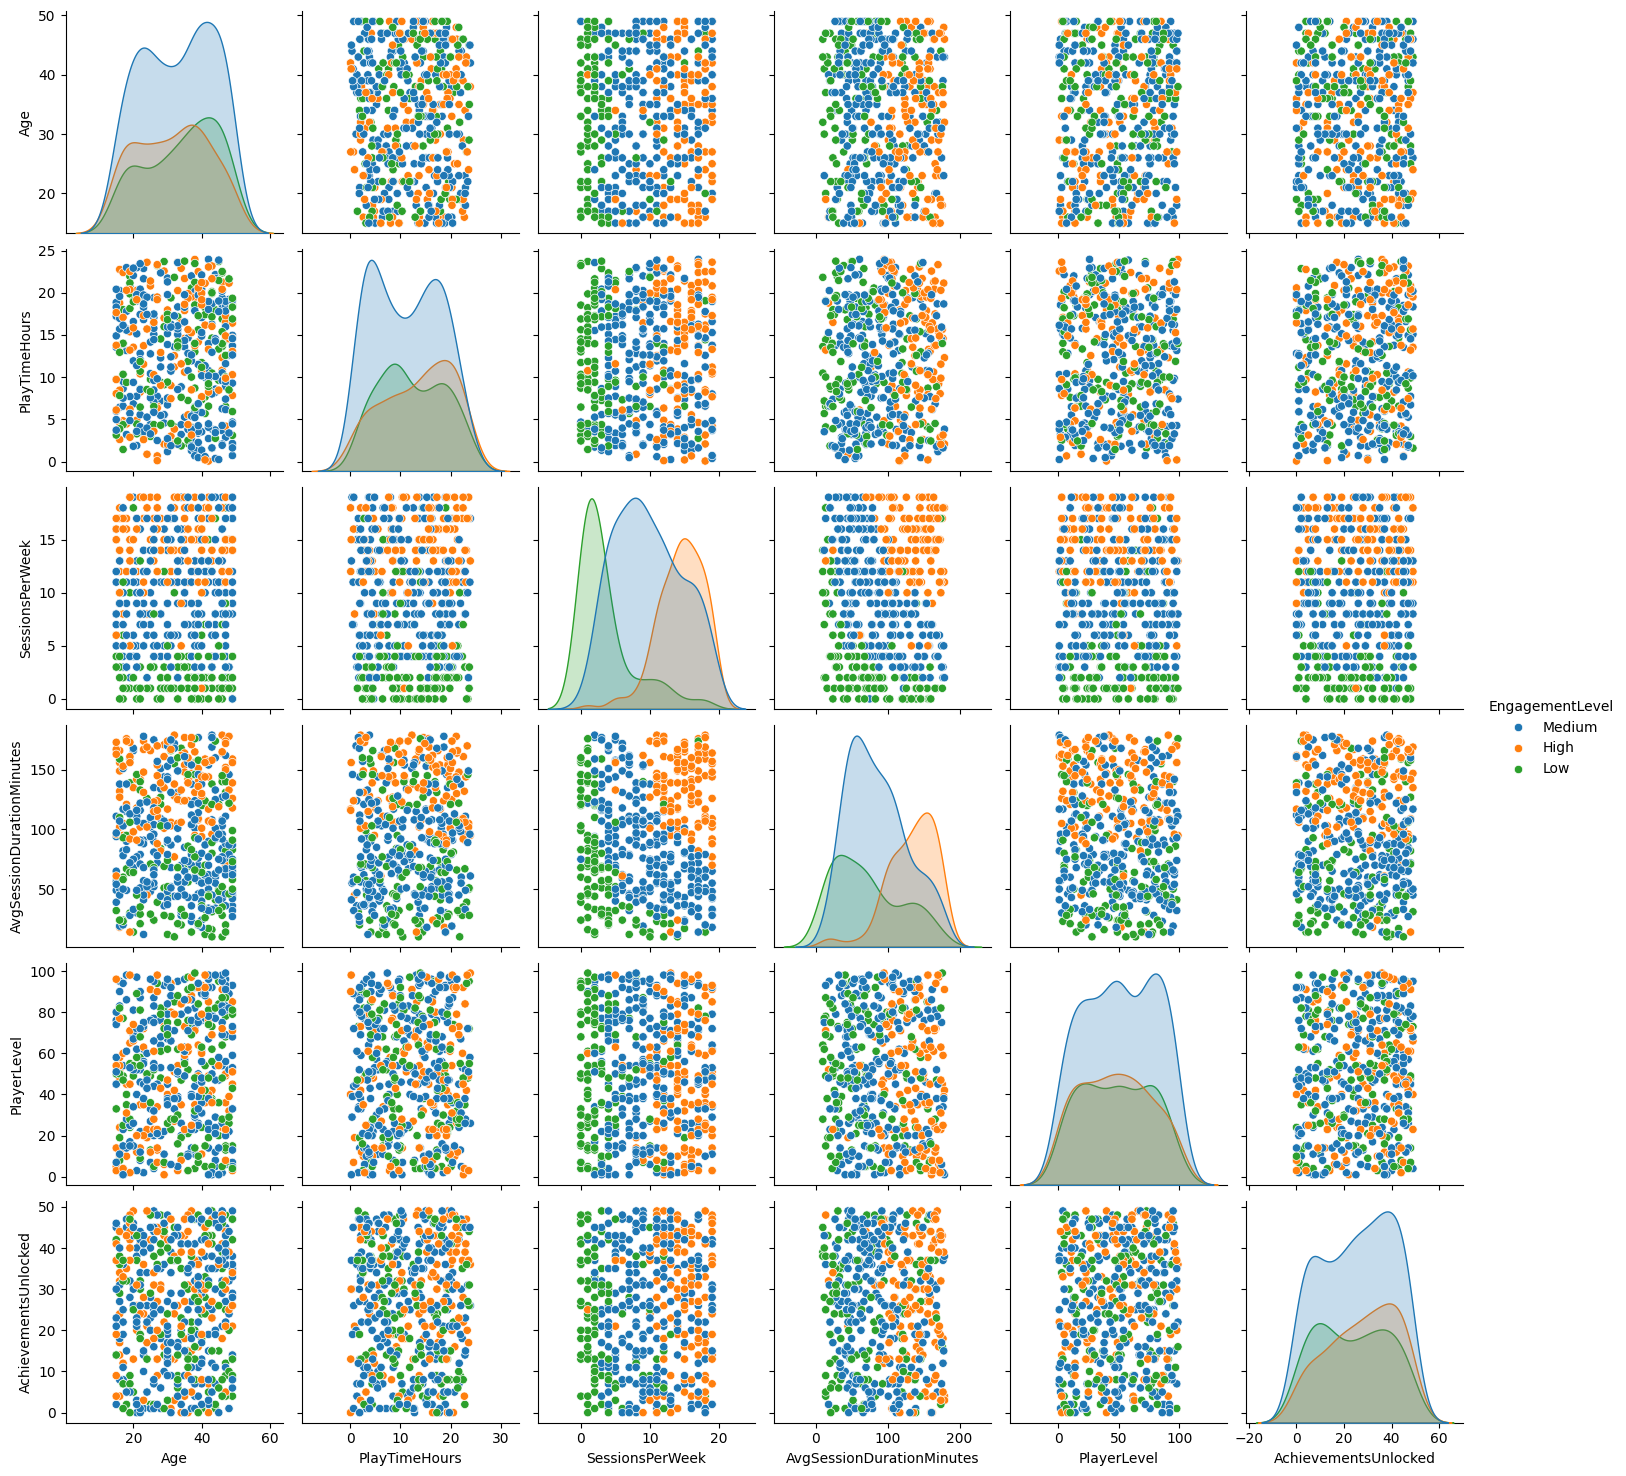

In [46]:
#Визуализация данных
sns.pairplot(data[:500], hue='EngagementLevel')
plt.show()

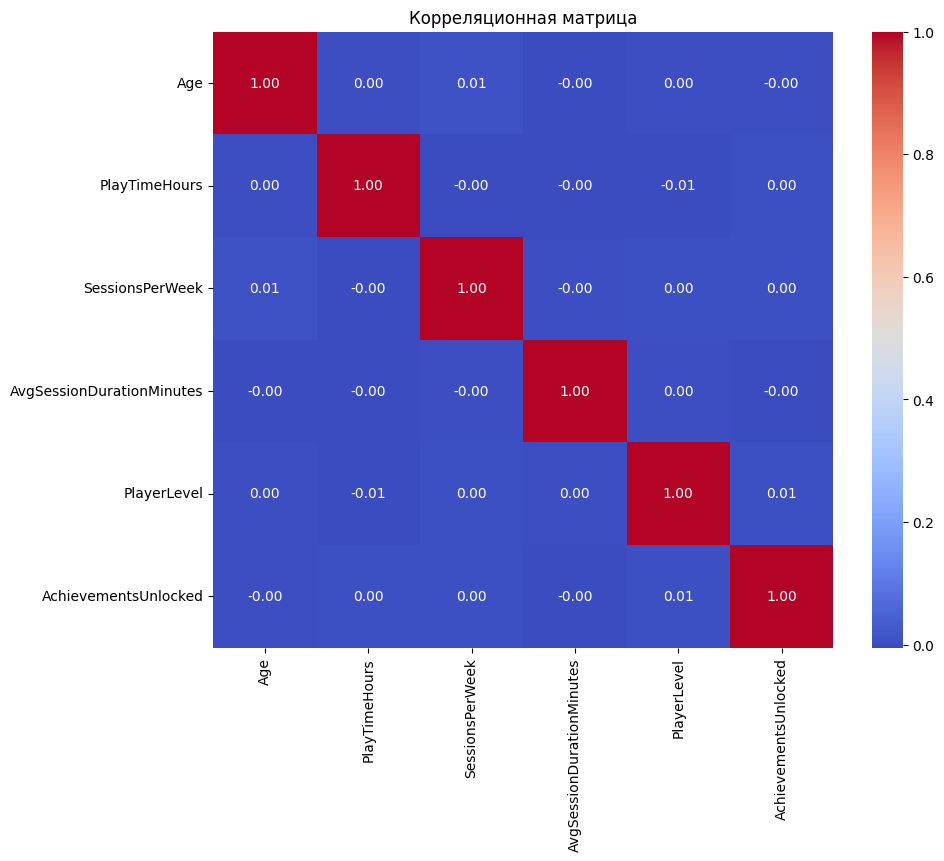

In [47]:
#Корреляционная матрица
plt.figure(figsize=(10, 8))
corr_matrix = data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

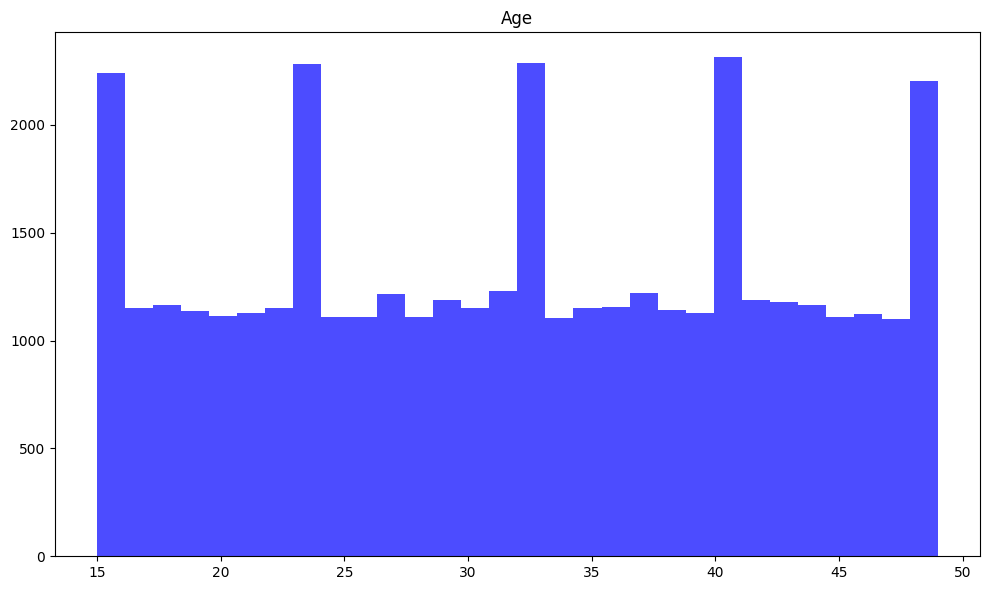

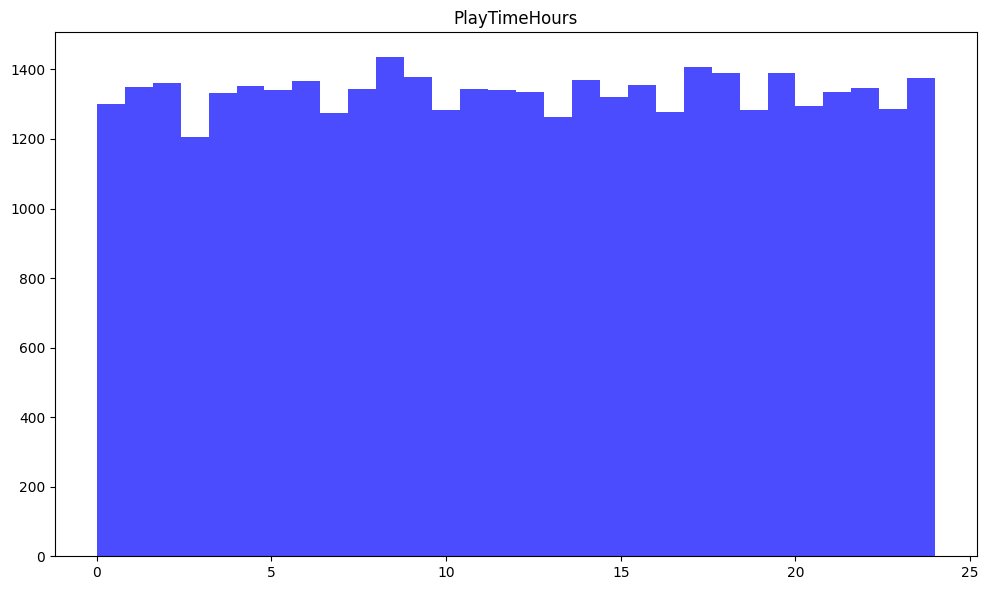

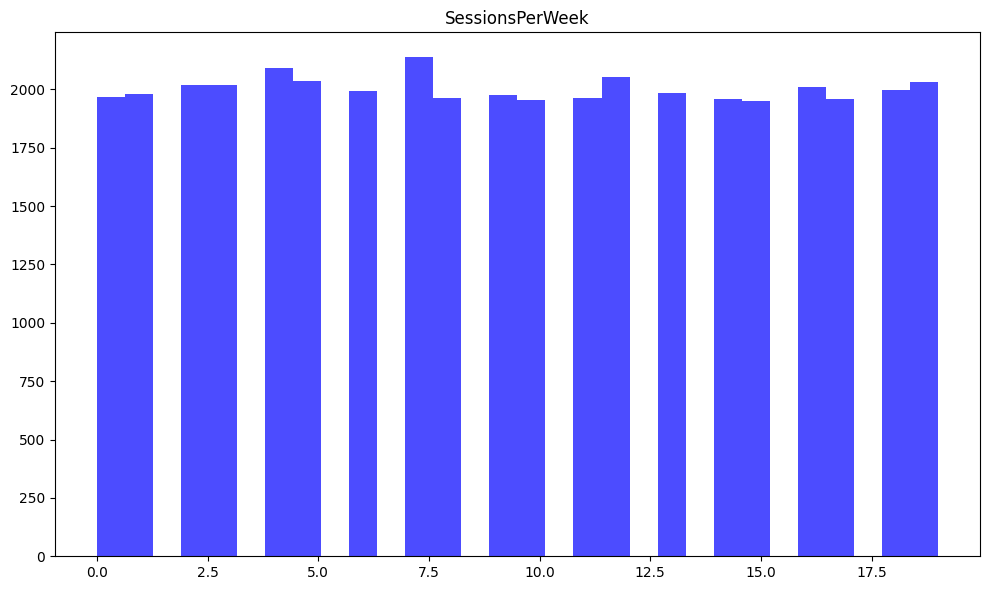

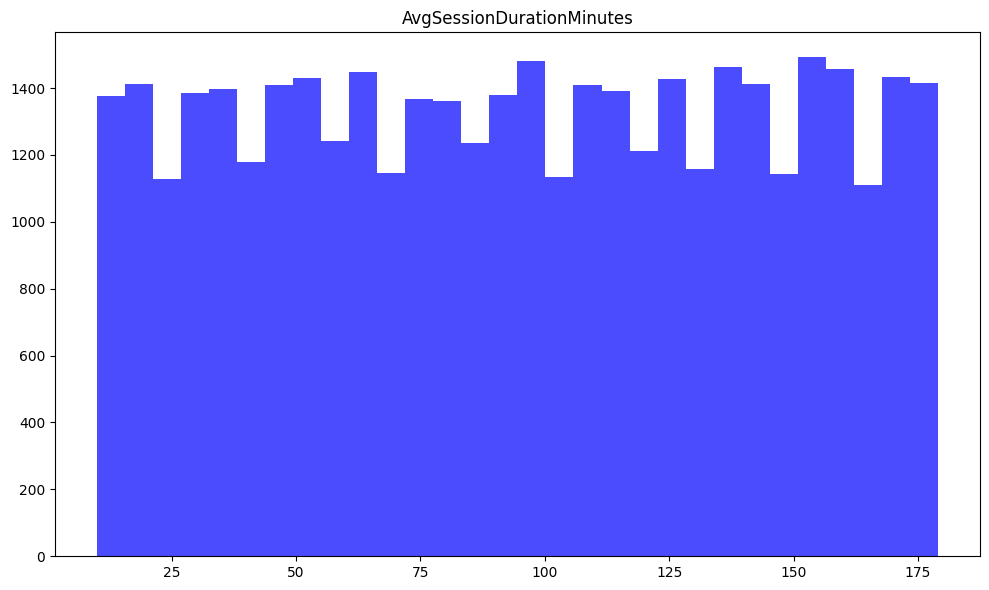

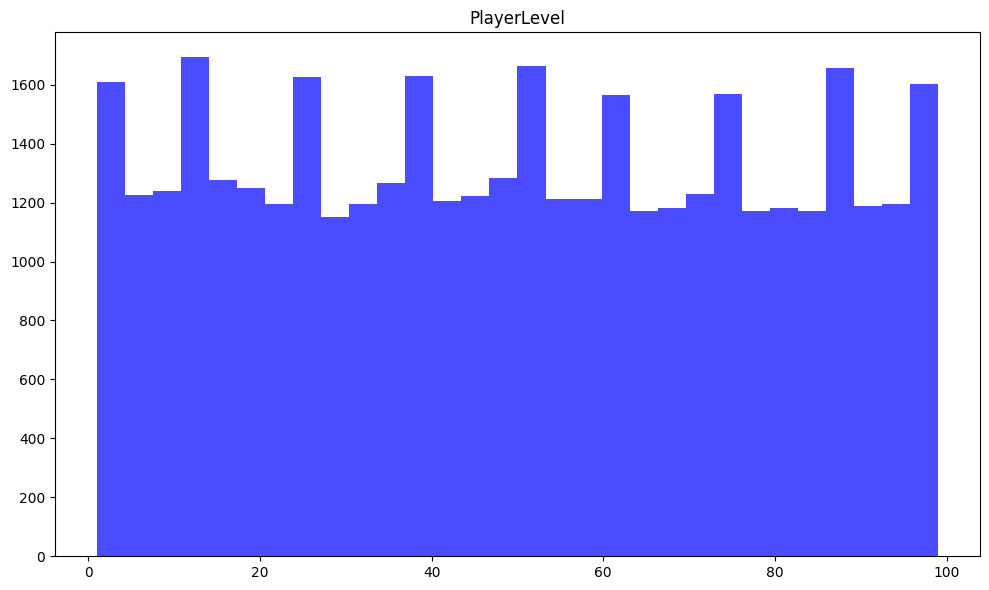

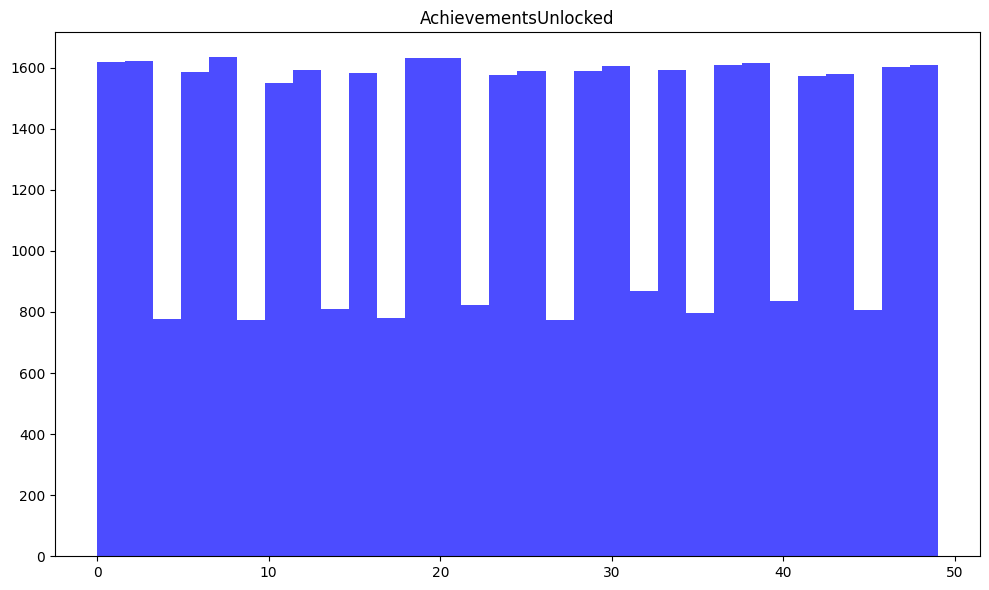

In [48]:
#Гистограммы для числовых значений
numeric_features = ['Age', 'PlayTimeHours', 'SessionsPerWeek',
                    'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked']

for num_column in numeric_features:
  dp.histogram(data[num_column], num_column)

In [49]:
data.columns

Index(['Age', 'Gender', 'Location', 'GameGenre', 'PlayTimeHours',
       'GameDifficulty', 'SessionsPerWeek', 'AvgSessionDurationMinutes',
       'PlayerLevel', 'AchievementsUnlocked', 'EngagementLevel'],
      dtype='object')

In [50]:
#Предобработка данных перед обучением моделей
target_column = 'EngagementLevel'
numeric_features = ['Age', 'PlayTimeHours',
                    'SessionsPerWeek', 'AvgSessionDurationMinutes',
                    'PlayerLevel', 'AchievementsUnlocked']
categorical_features = ['Gender', 'Location', 'GameGenre', 'GameDifficulty']

X, y, preprocessor = dp.preprocess_data(data, target_column, numeric_features, categorical_features)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

le = LabelEncoder()
y_train_XGB = le.fit_transform(y_train)
y_test_XGB = le.transform(y_test)

In [51]:
#Создание и обучение моделей

model_1 = LogisticRegression()
model_2 = RandomForestClassifier()
model_3 = XGBClassifier(max_depth=0)

model_1.fit(X_train, y_train)
model_2.fit(X_train, y_train)
model_3.fit(X_train, y_train_XGB)

y_pred_1 = model_1.predict(X_test)
y_pred_2 = model_2.predict(X_test)
y_pred_3 = model_3.predict(X_test)

#Метрики модели 1
accuracy_1 = accuracy_score(y_test, y_pred_1)
print(f"Точность модели: {accuracy_1:.2f}")

cm_1 = confusion_matrix(y_test, y_pred_1)
print("Матрица истинности:")
print(cm_1)

cr_1 = classification_report(y_test, y_pred_1, target_names=['Medium', 'High', 'Low'])
print("Классификационный отчет:")
print(cr_1)
print('\n')

#Метрики модели 2
accuracy_2 = accuracy_score(y_test, y_pred_2)
print(f"Точность модели: {accuracy_2:.2f}")

cm_2 = confusion_matrix(y_test, y_pred_2)
print("Матрица истинности:")
print(cm_2)

cr_2 = classification_report(y_test, y_pred_2, target_names=['Medium', 'High', 'Low'])
print("Классификационный отчет:")
print(cr_2)
print('\n')

#Метрики модели 3
accuracy_3 = accuracy_score(y_test_XGB, y_pred_3)
print(f"Точность модели: {accuracy_3:.2f}")

cm_3 = confusion_matrix(y_test_XGB, y_pred_3)
print("Матрица истинности:")
print(cm_3)

cr_3 = classification_report(y_test_XGB, y_pred_3, target_names=['Medium', 'High', 'Low'])
print("Классификационный отчет:")
print(cr_3)

Точность модели: 0.82
Матрица истинности:
[[2587   99  415]
 [  92 2146  859]
 [ 223  439 5151]]
Классификационный отчет:
              precision    recall  f1-score   support

      Medium       0.89      0.83      0.86      3101
        High       0.80      0.69      0.74      3097
         Low       0.80      0.89      0.84      5813

    accuracy                           0.82     12011
   macro avg       0.83      0.80      0.82     12011
weighted avg       0.82      0.82      0.82     12011



Точность модели: 0.91
Матрица истинности:
[[2684  107  310]
 [  91 2709  297]
 [ 144  157 5512]]
Классификационный отчет:
              precision    recall  f1-score   support

      Medium       0.92      0.87      0.89      3101
        High       0.91      0.87      0.89      3097
         Low       0.90      0.95      0.92      5813

    accuracy                           0.91     12011
   macro avg       0.91      0.90      0.90     12011
weighted avg       0.91      0.91      0.91    